In [1]:
import pyodbc
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
from scipy.stats import ttest_rel
import calendar
import warnings
from scipy import stats
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
import pickle
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import seaborn as sns
warnings.filterwarnings('ignore')
# Configure inline mode
%matplotlib inline
import random
from random import sample
import geopandas 
import geopandas as gpd
import joblib
from numpy.random import rand
import copy
# from dataprep.eda import *
pd.set_option('display.max_columns', None)


## Data preparation

In [9]:
df = pd.read_csv('Session-Details-Summary-20191205.csv', index_col=None)

df.dropna(subset=['Start Date', 'End Date'],inplace=True)


df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'] )

df = df[-df['EVSE ID'].isin({115301, 109869, 143791, 115155, 116983, 115675})]  #remove too few records from 471 (in original dataset) to 465

df.reset_index(drop=True,inplace=True)

In [10]:
intersection_station_zip = pd.read_csv('intersection_station_zip.csv', index_col=None)
intersection_station_zip
df_wrong_station_zip = intersection_station_zip[intersection_station_zip['postal_cod']!=intersection_station_zip['GEOID10']]
df_wrong_station_zip  # not complete, some stations in df may have two zip codes

# correct stations with wrong postal code
for i in intersection_station_zip.index:
    df.loc[df['EVSE ID']==intersection_station_zip.loc[i,'evse_id'],'Postal Code']=int(intersection_station_zip.loc[i,'ZCTA5CE10'])


In [388]:
intersection_station_zip

,evse_id,postal_cod,latitude,longitude,port_type,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10
0,5064.0,64145.0,38.884266,-94.607437,Level 2,64145,8600000US64145,64145,17067411,144490
1,5403.0,64108.0,39.084740,-94.587158,Level 2,64108,8600000US64108,64108,9405486,4803
2,6256.0,64154.0,39.300255,-94.663673,Level 2,64154,8600000US64154,64154,36046647,115690
3,9733.0,64105.0,39.093590,-94.587509,Level 2,64108,8600000US64108,64108,9405486,4803
4,9737.0,64105.0,39.093590,-94.587486,Level 2,64108,8600000US64108,64108,9405486,4803
...,...,...,...,...,...,...,...,...,...,...
466,415861.0,64105.0,39.099380,-94.583969,Level 2,64105,8600000US64105,64105,1950214,220454
467,495591.0,64105.0,39.099380,-94.584015,Level 2,64105,8600000US64105,64105,1950214,220454
468,495681.0,64105.0,39.099380,-94.584068,Level 2,64105,8600000US64105,64105,1950214,220454
469,1853721.0,64116.0,39.149055,-94.569183,Level 2,64116,8600000US64116,64116,28114226,1918265


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226541 entries, 0 to 226540
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Station Name                     226541 non-null  object        
 1   MAC Address                      226541 non-null  object        
 2   Org Name                         226541 non-null  object        
 3   Start Date                       226541 non-null  datetime64[ns]
 4   Start Time Zone                  226541 non-null  object        
 5   End Date                         226541 non-null  datetime64[ns]
 6   End Time Zone                    226541 non-null  object        
 7   Transaction Date (Pacific Time)  226382 non-null  object        
 8   Total Duration (hh:mm:ss)        226541 non-null  object        
 9   Charging Time (hh:mm:ss)         226541 non-null  object        
 10  Energy (kWh)                     226541 non-

In [23]:
# stations in the boundary of kcmo
df_Intersection_station_zip_471_boundary_450 = pd.read_csv('Intersection_station_zip_471_boundary_450.csv', index_col=None)

df = df[df['EVSE ID'].isin(df_Intersection_station_zip_471_boundary_450['evse_id'])] #450-{115301, 109869, 143791, 115155, 116983, 115675}
df.reset_index(drop=True,inplace=True)  #444 stations


In [800]:
df_group=df.groupby('EVSE ID')

for j in range(len(list(df_group.groups.keys()))):
    x = list(df_group.groups.keys())[j]  #key
    y = df.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe

print(len(list(df_group.groups.keys()))) #444


444


In [5]:
df_station_gis=pd.DataFrame()
df_group=df.groupby('EVSE ID')

for j in range(len(list(df_group.groups.keys()))):
    x = list(df_group.groups.keys())[j]  #key
    y = df.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe
    
    # y['Postal Code']
    df_station_gis = df_station_gis.append({'evse_id':int(x),\
        'postal_code':int(y['Postal Code'].values[0]),\
        'latitude':y['Latitude'].values[0],\
            'longitude':y['Longitude'].values[0],\
                'port_type':y['Port Type'].values[0]}, ignore_index=True)



In [21]:
df_station_gis

,evse_id,postal_code,latitude,longitude,port_type,geometry
0,5064.0,64145.0,38.884266,-94.607437,Level 2,POINT (-94.60744 38.88427)
1,5403.0,64108.0,39.084740,-94.587158,Level 2,POINT (-94.58716 39.08474)
2,6256.0,64154.0,39.300255,-94.663673,Level 2,POINT (-94.66367 39.30025)
3,9733.0,64108.0,39.093590,-94.587509,Level 2,POINT (-94.58751 39.09359)
4,9737.0,64108.0,39.093590,-94.587486,Level 2,POINT (-94.58749 39.09359)
...,...,...,...,...,...,...
439,235551.0,64105.0,39.100243,-94.586250,Level 2,POINT (-94.58625 39.10024)
440,237281.0,64105.0,39.100174,-94.586136,Level 2,POINT (-94.58614 39.10017)
441,415861.0,64105.0,39.099380,-94.583969,Level 2,POINT (-94.58397 39.09938)
442,495681.0,64105.0,39.099380,-94.584068,Level 2,POINT (-94.58407 39.09938)


In [27]:
df_station_gis.to_csv('df_station_gis_inbound_444.csv',index = False)

In [16]:
import joblib

# joblib.dump(df, 'df_pocesssed_inbound.pkl')
# df = joblib.load("df_pocesssed_inbound.pkl")

### num_of_nearby_station data

In [29]:
df['num_of_nearby_station']=0
df['id_of_nearby_station']=None

df_group_postal=df.groupby('Postal Code')

for j in range(len(list(df_group_postal.groups.keys()))):
    x = list(df_group_postal.groups.keys())[j]  #key
    y = df.loc[df_group_postal.groups[list(df_group_postal.groups.keys())[j]],:]  #extracted dataframe
    df.loc[df['Postal Code']==x,'id_of_nearby_station'] = [set(y['EVSE ID'])]*len(df.loc[df['Postal Code']==x,'id_of_nearby_station'])
    df.loc[df['Postal Code']==x,'num_of_nearby_station'] = len(set(y['EVSE ID']))

print(len(list(df_group_postal.groups.keys())))

In [33]:
df['charging_time_str'] = df['Charging Time (hh:mm:ss)'].str.split(':')
df['charging_time_hour'] = df['charging_time_str'].apply(lambda x: int(x[2])/3600+int(x[1])/60+int(x[0]))

In [34]:
dict_station_rate = {}
k = 0

df_group=df.groupby('EVSE ID')

for j in range(len(list(df_group.groups.keys()))):
    x = list(df_group.groups.keys())[j]  #key
    y = df.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe
    
    y_group=y.groupby(pd.Grouper(key="Start Date", freq="1W"))

    # groups to a list of dataframes with list comprehension
    dfs = [group for _,group in y_group]
    dfx = [x for x,group in y_group] #must remove head and tail because it is not a full week
    if len(dfs)-1 <2:
        print(x)

    
    for i in range(1,len(dfs)-1):
        dict_station_rate[k] = {'EVSE ID':x,\
            'postal_code':y['Postal Code'].values[0],\
                'lat':y['Latitude'].values[0],\
                    'lon':y['Longitude'].values[0],\
            'duration_start':dfx[i-1],\
                'duration_end':dfx[i],\
                    'record_count':len(dfs[i]),\
                        'num_of_nearby_station':y['num_of_nearby_station'].values[0],\
                            'port_type':y['Port Type'].values[0],\
                                'charging_time_hour':y['charging_time_hour'].sum()}
        k += 1
df_station_rate = pd.DataFrame(dict_station_rate).transpose()
df_station_rate['record_count'] = df_station_rate['record_count'].astype(int)
df_station_rate['num_of_nearby_station'] = df_station_rate['num_of_nearby_station'].astype(int)
df_station_rate  #444

,EVSE ID,postal_code,lat,lon,duration_start,duration_end,record_count,num_of_nearby_station,port_type,charging_time_hour
0,5064,64145,38.884266,-94.607437,2014-01-05,2014-01-12,3,4,Level 2,120.341389
1,5064,64145,38.884266,-94.607437,2014-01-12,2014-01-19,3,4,Level 2,120.341389
2,5064,64145,38.884266,-94.607437,2014-01-19,2014-01-26,3,4,Level 2,120.341389
3,5064,64145,38.884266,-94.607437,2014-01-26,2014-02-02,7,4,Level 2,120.341389
4,5064,64145,38.884266,-94.607437,2014-02-02,2014-02-09,2,4,Level 2,120.341389
...,...,...,...,...,...,...,...,...,...,...
67571,1901501,64108,39.078888,-94.598068,2019-10-27,2019-11-03,6,77,Level 2,127.610556
67572,1901501,64108,39.078888,-94.598068,2019-11-03,2019-11-10,8,77,Level 2,127.610556
67573,1901501,64108,39.078888,-94.598068,2019-11-10,2019-11-17,7,77,Level 2,127.610556
67574,1901501,64108,39.078888,-94.598068,2019-11-17,2019-11-24,4,77,Level 2,127.610556


### weather data

In [332]:
df_weather_kc = pd.read_csv('weather_kc.csv', index_col=None)
df_weather_kc['Date'] = pd.to_datetime(df_weather_kc['DATE'] )

df_station_rate['weekly_precipitation']=0
df_station_rate['weekly_temp']=0
df_station_rate['weekly_wind']=0



for i in range(len(df_station_rate)):
    df_weather_kc_sub = df_weather_kc[(df_weather_kc['Date'] > df_station_rate.loc[i , 'duration_start']) & \
    (df_weather_kc['Date'] <= df_station_rate.loc[i , 'duration_end'])]

    df_station_rate.loc[i,'weekly_precipitation'] = df_weather_kc_sub['PRCP'].sum()
    df_station_rate.loc[i,'weekly_temp'] = df_weather_kc_sub['TAVG'].mean()
    df_station_rate.loc[i,'weekly_wind'] = df_weather_kc_sub['AWND'].mean()

### landuse data

In [71]:
df_landuse_parcel = gpd.read_file("landuse_parcel.shp")
df_landuse_code = pd.read_csv('Land_Use_Codes.csv', index_col=None)
df_landuse_code

,Land_Use_Code,Land_Use_Description,Label
0,1111,Single Family (Non-Mobile Home Park),residential
1,1112,Mobile Home Park,residential
2,1121,Townhouse,residential
3,1122,Duplex,residential
4,1123,Multifamily - 3 units,residential
...,...,...,...
61,9280,Condo untested for residence or common area,vacant
62,9300,Underground Space,vacant
63,9400,Permanent Open Space (e.g. flood),vacant
64,9500,Vacant Residential,vacant


In [142]:
df_landuse_parcel['centroid'] = df_landuse_parcel.centroid
df_landuse_parcel['centroid_x'] = df_landuse_parcel.centroid.x
df_landuse_parcel['centroid_y'] = df_landuse_parcel.centroid.y

In [143]:
df_landuse_parcel["landuse_type"]=None
for i in df_landuse_parcel.index:
    try:
        df_landuse_parcel.at[i,'landuse_type'] = df_landuse_code[df_landuse_code['Land_Use_Code']==df_landuse_parcel.loc[i,"LANDUSECOD"]]['Label'].values[0]
    except:
        df_landuse_parcel.at[i,'landuse_type'] = 'unknown'



In [63]:
df_landuse_parcel["landuse_type"].value_counts()

residential      158021
unknown           60167
vacant            25509
recreation         3865
commercial         3784
industry           2846
transportaion      2720
institutional      2186
Name: landuse_type, dtype: int64

In [177]:
# fix unknown in df_landuse_parcel
df_landuse_parcel_unknown = df_landuse_parcel[df_landuse_parcel["landuse_type"]=='unknown']
df_landuse_parcel_known = df_landuse_parcel[df_landuse_parcel["landuse_type"]!='unknown']
for i in df_landuse_parcel_unknown.index:
    distance_two_parcels = np.linalg.norm(df_landuse_parcel_unknown.loc[i,['centroid_x','centroid_y']].values.astype(float) -\
        df_landuse_parcel_known.loc[:,['centroid_x','centroid_y']].values,axis=1)
    df_parcel_known_nearby = df_landuse_parcel_known[distance_two_parcels<1000]
    try:
        df_landuse_parcel_unknown.loc[i,'landuse_type'] = df_parcel_known_nearby['landuse_type'].mode().values[0]
    except:
        df_parcel_known_nearby = df_landuse_parcel_known[distance_two_parcels<3000]
        df_landuse_parcel_unknown.loc[i,'landuse_type'] = df_parcel_known_nearby['landuse_type'].mode().values[0]
        
df_landuse_parcel.loc[df_landuse_parcel_unknown.index,'landuse_type'] = df_landuse_parcel_unknown["landuse_type"]

In [181]:
df_landuse_parcel_unknown["landuse_type"].value_counts()

residential      48247
vacant            4859
transportaion     2525
industry          1575
institutional     1367
commercial        1258
recreation         336
Name: landuse_type, dtype: int64

In [263]:
df_landuse_parcel["landuse_type"].value_counts()

residential      206268
vacant            30368
transportaion      5245
commercial         5042
industry           4421
recreation         4201
institutional      3553
Name: landuse_type, dtype: int64

In [294]:
# fix unknow in intersection_station_landuse
intersection_station_landuse = pd.read_csv('site_selection_gis/intersection_station_landuse.csv', index_col=None)

for i in intersection_station_landuse.index:
    intersection_station_landuse.loc[i,'landuse_type']=\
        df_landuse_parcel[df_landuse_parcel['OBJECTID'] == intersection_station_landuse.loc[i,'OBJECTID']]['landuse_type'].values[0]
    

In [295]:


print(len(set(intersection_station_landuse['evse_id'])))
print(len(set(df['EVSE ID'])))
print(set(df['EVSE ID'])-set(intersection_station_landuse['evse_id']))

442
444
{113025, 115555, 117767, 110511, 115447, 110235, 115549, 116191}


In [296]:
intersection_station_landuse_442 = pd.DataFrame()

df_group_intersection_station_landuse =intersection_station_landuse.groupby('evse_id')

for j in range(len(list(df_group_intersection_station_landuse.groups.keys()))):
    x = list(df_group_intersection_station_landuse.groups.keys())[j]  #key
    y = intersection_station_landuse.loc[df_group_intersection_station_landuse.groups[list(df_group_intersection_station_landuse.groups.keys())[j]],:]  #extracted dataframe
    intersection_station_landuse_442 = intersection_station_landuse_442.append(y.iloc[[0]],ignore_index=True )

In [297]:
#the eight stations fail to overlap with landuse parcel. we should use buffer function in qgis to find the nearest parcel. but here we just manually determine it
dict_evse_id_landuse = {110235:'recreation',\
110511:'recreation',\
113025:'institutional',\
115447:'recreation',\
115549:'recreation',\
115555:'recreation',\
116191:'residential',\
117767:'residential'}

In [298]:
df_station_rate['landuse_type'] = None
df_group_station_rate = df_station_rate.groupby('EVSE ID')

for j in range(len(list(df_group_station_rate.groups.keys()))):
    x = list(df_group_station_rate.groups.keys())[j]  #key
    y = df_station_rate.loc[df_group_station_rate.groups[list(df_group_station_rate.groups.keys())[j]],:]  #extracted dataframe
    try:
        df_station_rate.loc[df_station_rate['EVSE ID']==x,'landuse_type']=\
            intersection_station_landuse_442.loc[intersection_station_landuse_442['evse_id']==x,'landuse_type'].values[0]
    except:
        # print(x)
        df_station_rate.loc[df_station_rate['EVSE ID']==x,'landuse_type']=dict_evse_id_landuse[x]
        

In [302]:
port_type = pd.get_dummies(df_station_rate['port_type'], prefix = 'port_type')
landuse_type = pd.get_dummies(df_station_rate['landuse_type'], prefix = 'landuse_type')
df_station_rate_1 = pd.concat([df_station_rate.drop(['port_type','landuse_type'],axis=1), port_type,landuse_type],axis=1)


In [303]:
df_station_rate_1

,EVSE ID,postal_code,lat,lon,duration_start,duration_end,record_count,num_of_nearby_station,charging_time_hour,weekly_precipitation,weekly_temp,weekly_wind,port_type_DC Fast,port_type_Level 2,landuse_type_commercial,landuse_type_industry,landuse_type_institutional,landuse_type_recreation,landuse_type_residential,landuse_type_transportaion,landuse_type_vacant
0,5064,64145,38.884266,-94.607437,2014-01-05,2014-01-12,3,4,120.341389,0.6,-4.814286,4.571429,0,1,1,0,0,0,0,0,0
1,5064,64145,38.884266,-94.607437,2014-01-12,2014-01-19,3,4,120.341389,0.0,0.871429,5.914286,0,1,1,0,0,0,0,0,0
2,5064,64145,38.884266,-94.607437,2014-01-19,2014-01-26,3,4,120.341389,0.0,-2.285714,6.057143,0,1,1,0,0,0,0,0,0
3,5064,64145,38.884266,-94.607437,2014-01-26,2014-02-02,7,4,120.341389,8.7,-6.442857,5.242857,0,1,1,0,0,0,0,0,0
4,5064,64145,38.884266,-94.607437,2014-02-02,2014-02-09,2,4,120.341389,12.0,-10.100000,4.157143,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67571,1901501,64108,39.078888,-94.598068,2019-10-27,2019-11-03,6,77,127.610556,6.9,2.814286,4.414286,0,1,0,1,0,0,0,0,0
67572,1901501,64108,39.078888,-94.598068,2019-11-03,2019-11-10,8,77,127.610556,0.0,6.071429,4.342857,0,1,0,1,0,0,0,0,0
67573,1901501,64108,39.078888,-94.598068,2019-11-10,2019-11-17,7,77,127.610556,1.3,1.471429,4.685714,0,1,0,1,0,0,0,0,0
67574,1901501,64108,39.078888,-94.598068,2019-11-17,2019-11-24,4,77,127.610556,7.3,6.871429,4.585714,0,1,0,1,0,0,0,0,0


### traffic data

In [342]:
df_station_taz_intersection = pd.read_csv('station_taz_intersection.csv', index_col=None)
df_daily_od_trips = pd.read_csv('DailyODTrips.csv', index_col=None)
df_links = pd.read_csv('links.csv', index_col=None)
df_nodes = pd.read_csv('nodes.csv', index_col=None)

In [305]:
df_station_rate_1['attraction']=0

for i in range(len(df_station_taz_intersection)):
    df_station_rate_1.loc[df_station_rate_1['EVSE ID']==df_station_taz_intersection.loc[i,'EVSE.ID'],'attraction'] =\
         df_station_taz_intersection.loc[i,'ATTRACTION']

# the attraction for EVSE_ID =115573 and 173281 are missing
# df_station_taz_intersection[df_station_taz_intersection['EVSE.ID']==115573]
# df_station_taz_intersection[df_station_taz_intersection['EVSE.ID']==173281]

df_station_rate_1.at[df_station_rate_1['EVSE ID']==115573,'attraction'] = df_station_taz_intersection['ATTRACTION'].mean()
df_station_rate_1.at[df_station_rate_1['EVSE ID']==173281,'attraction'] = df_station_taz_intersection['ATTRACTION'].mean()

In [306]:
df_station_rate_1

,EVSE ID,postal_code,lat,lon,duration_start,duration_end,record_count,num_of_nearby_station,charging_time_hour,weekly_precipitation,weekly_temp,weekly_wind,port_type_DC Fast,port_type_Level 2,landuse_type_commercial,landuse_type_industry,landuse_type_institutional,landuse_type_recreation,landuse_type_residential,landuse_type_transportaion,landuse_type_vacant,attraction
0,5064,64145,38.884266,-94.607437,2014-01-05,2014-01-12,3,4,120.341389,0.6,-4.814286,4.571429,0,1,1,0,0,0,0,0,0,6172.18
1,5064,64145,38.884266,-94.607437,2014-01-12,2014-01-19,3,4,120.341389,0.0,0.871429,5.914286,0,1,1,0,0,0,0,0,0,6172.18
2,5064,64145,38.884266,-94.607437,2014-01-19,2014-01-26,3,4,120.341389,0.0,-2.285714,6.057143,0,1,1,0,0,0,0,0,0,6172.18
3,5064,64145,38.884266,-94.607437,2014-01-26,2014-02-02,7,4,120.341389,8.7,-6.442857,5.242857,0,1,1,0,0,0,0,0,0,6172.18
4,5064,64145,38.884266,-94.607437,2014-02-02,2014-02-09,2,4,120.341389,12.0,-10.100000,4.157143,0,1,1,0,0,0,0,0,0,6172.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67571,1901501,64108,39.078888,-94.598068,2019-10-27,2019-11-03,6,77,127.610556,6.9,2.814286,4.414286,0,1,0,1,0,0,0,0,0,2232.14
67572,1901501,64108,39.078888,-94.598068,2019-11-03,2019-11-10,8,77,127.610556,0.0,6.071429,4.342857,0,1,0,1,0,0,0,0,0,2232.14
67573,1901501,64108,39.078888,-94.598068,2019-11-10,2019-11-17,7,77,127.610556,1.3,1.471429,4.685714,0,1,0,1,0,0,0,0,0,2232.14
67574,1901501,64108,39.078888,-94.598068,2019-11-17,2019-11-24,4,77,127.610556,7.3,6.871429,4.585714,0,1,0,1,0,0,0,0,0,2232.14


In [340]:
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [308]:
df_station_rate_1['nearby_traffic'] = 0  
df_group_evse_id=df.groupby('EVSE ID')

for j in range(len(list(df_group_evse_id.groups.keys()))):
    x = list(df_group_evse_id.groups.keys())[j]  #key
    y = df.loc[df_group_evse_id.groups[list(df_group_evse_id.groups.keys())[j]],:]  #extracted dataframe

    distance_to_node = haversine_vectorize(df_nodes['Longitude'],df_nodes['Latitude'],y['Longitude'].values[0],y['Latitude'].values[0])
    df_nodes_nearby = df_nodes[distance_to_node<1]
    nearby_traffic_mean = df_links[df_links['start'].isin(df_nodes_nearby['Waypoint'].values)]['vol'].mean()

    df_station_rate_1.loc[df_station_rate_1['EVSE ID']==x,'nearby_traffic'] = nearby_traffic_mean



## Stage 1 model

### Dataset split

In [14]:
predictor = df_station_rate_1[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

target = df_station_rate_1[['record_count']]

In [791]:
df_station_rate_1

,EVSE ID,postal_code,lat,lon,duration_start,duration_end,record_count,num_of_nearby_station,charging_time_hour,weekly_precipitation,weekly_temp,weekly_wind,port_type_DC Fast,port_type_Level 2,landuse_type_commercial,landuse_type_industry,landuse_type_institutional,landuse_type_recreation,landuse_type_residential,landuse_type_transportaion,landuse_type_vacant,attraction,nearby_traffic
0,5064,64145,38.884266,-94.607437,2014-01-05,2014-01-12,3,4,120.341389,0.6,-4.814286,4.571429,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
1,5064,64145,38.884266,-94.607437,2014-01-12,2014-01-19,3,4,120.341389,0.0,0.871429,5.914286,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
2,5064,64145,38.884266,-94.607437,2014-01-19,2014-01-26,3,4,120.341389,0.0,-2.285714,6.057143,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
3,5064,64145,38.884266,-94.607437,2014-01-26,2014-02-02,7,4,120.341389,8.7,-6.442857,5.242857,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
4,5064,64145,38.884266,-94.607437,2014-02-02,2014-02-09,2,4,120.341389,12.0,-10.100000,4.157143,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67571,1901501,64108,39.078888,-94.598068,2019-10-27,2019-11-03,6,77,127.610556,6.9,2.814286,4.414286,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67572,1901501,64108,39.078888,-94.598068,2019-11-03,2019-11-10,8,77,127.610556,0.0,6.071429,4.342857,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67573,1901501,64108,39.078888,-94.598068,2019-11-10,2019-11-17,7,77,127.610556,1.3,1.471429,4.685714,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67574,1901501,64108,39.078888,-94.598068,2019-11-17,2019-11-24,4,77,127.610556,7.3,6.871429,4.585714,0,1,0,1,0,0,0,0,0,2232.14,7594.427083


In [315]:
predictor

,num_of_nearby_station,weekly_precipitation,weekly_temp,weekly_wind,port_type_DC Fast,port_type_Level 2,landuse_type_commercial,landuse_type_industry,landuse_type_institutional,landuse_type_recreation,landuse_type_residential,landuse_type_transportaion,landuse_type_vacant,attraction,nearby_traffic
0,4,0.6,-4.814286,4.571429,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
1,4,0.0,0.871429,5.914286,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
2,4,0.0,-2.285714,6.057143,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
3,4,8.7,-6.442857,5.242857,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
4,4,12.0,-10.100000,4.157143,0,1,1,0,0,0,0,0,0,6172.18,7329.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67571,77,6.9,2.814286,4.414286,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67572,77,0.0,6.071429,4.342857,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67573,77,1.3,1.471429,4.685714,0,1,0,1,0,0,0,0,0,2232.14,7594.427083
67574,77,7.3,6.871429,4.585714,0,1,0,1,0,0,0,0,0,2232.14,7594.427083


In [792]:
target

,record_count
0,3
1,3
2,3
3,7
4,2
...,...
67571,6
67572,8
67573,7
67574,4


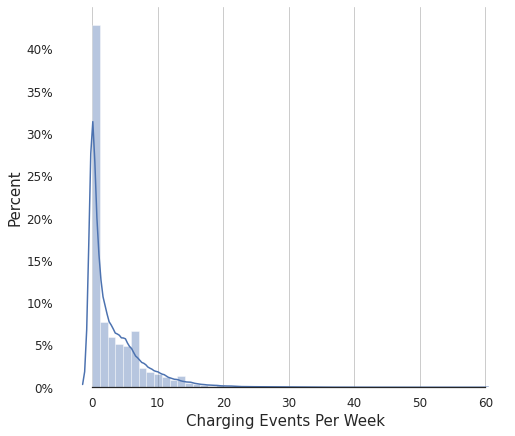

In [78]:

sns.set(font_scale = 1)
from scipy.stats import norm 
from  matplotlib.ticker import PercentFormatter
nbins = 10
xlen = np.linspace(-0.4,0.4,nbins)
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(target, color="b",hist=1, kde=True,norm_hist=1)
ax.xaxis.grid(True)
ax.set_xlabel('Charging Events Per Week',fontsize=15)
ax.set_ylabel('Percent',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set(title="SalePrice distribution")
ax.set_yticklabels(ax.get_yticks())
ax.yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
sns.despine(trim=True, left=True)
# plt.savefig("response variable distribtion.svg")
plt.show()

In [17]:
import joblib

# joblib.dump([df,df_station_rate_1,df_landuse_parcel,intersection_station_landuse_442], 'data_site_selection_v2.pkl')
# df,df_station_rate_1,df_landuse_parcel,intersection_station_landuse_442 = joblib.load("data_site_selection_v2.pkl")

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(predictor, target, test_size=0.2, random_state=42)

### parameter tuning

In [323]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



x_train, x_test, y_train, y_test = train_test_split(predictor, target, test_size=0.2, random_state=42)

# l1, absolute loss, aliases: mean_absolute_error, mae, regression_l1

# l2, square loss, aliases: mean_squared_error, mse, regression_l2, regression

# rmse, root square loss, aliases: root_mean_squared_error, l2_root



params = {
          'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'nthread':16,
          'learning_rate':0.1,
          'num_leaves':128, 
          'max_depth': 8,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8,
          "verbose": -1
    }
    
data_train = lgb.Dataset(x_train, y_train)
cv_results = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,early_stopping_rounds=50,seed=0)
print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', pd.Series(cv_results['rmse-mean']).min())



best n_estimators: 278
best cv score: 2.819808918024139


In [334]:
params_test1={'max_depth': range(15,30,2), 'num_leaves':range(5, 150, 10)} # 7*15=105 candidates 
              
gsearch1 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=len(cv_results['rmse-mean']), 
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                        param_grid = params_test1, 
                        scoring='neg_root_mean_squared_error',
                        cv=5,  #75*5=375 fits
                        n_jobs=-1,  #use all cores
                        verbose=1)  #the greater the number the more detail you will get

gsearch1.fit(x_train,y_train)
# gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_  #  ({'max_depth': 21, 'num_leaves': 55}, -2.817010417872229)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current v

({'max_depth': 21, 'num_leaves': 55}, -2.8136802157627407)

In [335]:
params_test2={'max_bin': range(5,600,20), 'min_data_in_leaf':range(0,52,10)}
              
gsearch2 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=len(cv_results['rmse-mean']), 
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                        param_grid = params_test2,
                        scoring='neg_root_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

gsearch2.fit(x_train,y_train)
# gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_  #({'max_bin': 325, 'min_data_in_leaf': 50}, -2.8135734328740227)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=0, min_child_samples=20 will be ignored. Curre

({'max_bin': 325, 'min_data_in_leaf': 50}, -2.809525868162519)

In [336]:
params_test3={'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,51,10)
}
              
gsearch3 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=len(cv_results['rmse-mean']), 
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf']), 
                        param_grid = params_test3, 
                        scoring='neg_root_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=0)
gsearch3.fit(x_train,y_train)
# gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_ #({'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.8}, -2.809525868162519)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsampl

({'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.8},
 -2.809525868162519)

In [337]:
params_test4={'lambda_l1': [0, 1e-4,1e-2,1e-1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [0, 1e-4,1e-2,1e-1,0.3,0.5,0.7,0.9,1.0]
}
              
gsearch4 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=len(cv_results['rmse-mean']), 
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'], 
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction']), 
                        param_grid = params_test4, 
                        scoring='neg_root_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=0)

gsearch4.fit(x_train,y_train)
# gsearch4.best_params_, 
gsearch4.best_params_, gsearch4.best_score_ #({'lambda_l1': 0.9, 'lambda_l2': 0.1}, -2.810720651075502)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Wa

({'lambda_l1': 0.9, 'lambda_l2': 0.1}, -2.8082174104145574)

In [338]:
params_test5={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
              
gsearch5 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=len(cv_results['rmse-mean']), 
                                                       max_depth=gsearch1.best_params_['max_depth'],  
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'], 
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction'],
                                                       lambda_l1=gsearch4.best_params_['lambda_l1'],
                                                       lambda_l2=gsearch4.best_params_['lambda_l2']), 
                        param_grid = params_test5, 
                        scoring='neg_root_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)

gsearch5.fit(x_train,y_train)
# gsearch5.best_params_, 
gsearch5.best_params_, gsearch5.best_score_ #({'min_split_gain': 0.0}, -2.8082174104145574)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5; 1/11] START min_split_gain=0.0.........................................
[CV 2/5; 1/11] START min_split_gain=0.0.........................................
[CV 3/5; 1/11] START min_split_gain=0.0.........................................
[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV 4/5; 1/11] STA

({'min_split_gain': 0.0}, -2.8082174104145574)

In [349]:
import sklearn.metrics as metrics

model=lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         metrics='rmse',
                         learning_rate=0.001, #
                         n_estimators=100000, #
                         max_depth=gsearch1.best_params_['max_depth'],
                         num_leaves=gsearch1.best_params_['num_leaves'],
                         max_bin=gsearch2.best_params_['max_bin'],
                         min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'],
                         bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                         bagging_freq= gsearch3.best_params_['bagging_freq'], 
                         feature_fraction= gsearch3.best_params_['feature_fraction'],
                         lambda_l1=gsearch4.best_params_['lambda_l1'],
                         lambda_l2=gsearch4.best_params_['lambda_l2'], 
                         min_split_gain=gsearch5.best_params_['min_split_gain'])

model.fit(x_train,
y_train,
eval_set=[(x_test, y_test)],
eval_metric='rmse',
early_stopping_rounds=1000,
verbose=False)

y_pre_train = model.predict(x_train)
y_pre_test=model.predict(x_test)

print(model.best_iteration_) #51896
print("training r2_score:",metrics.r2_score(y_train, y_pre_train)) #equal #print("explained_variance_score:",metrics.explained_variance_score(y_test, y_pre_test))
print("training mae:",metrics.mean_absolute_error(y_train, y_pre_train))
print("training mse:",metrics.mean_squared_error(y_train, y_pre_train)**0.5)

print("testing r2_score:",metrics.r2_score(y_test, y_pre_test)) #equal #print("explained_variance_score:",metrics.explained_variance_score(y_test, y_pre_test))
print("testing mae:",metrics.mean_absolute_error(y_test, y_pre_test))
print("testing mse:",metrics.mean_squared_error(y_test, y_pre_test)**0.5)

[LightGBM] [Warning] lambda_l1 is set=0.9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
training r2_score: 0.7180204877232554
training mae: 1.6157965467822908
training mse: 2.382294953910046
testing r2_score: 0.6291863427661062
testing mae: 1.8538716201008079
testing mse: 2.7738900672424247


In [16]:
y_pre_train = model.predict(x_train)
y_pre_test=model.predict(x_test)

print(model.best_iteration_) #51896
print("training r2_score:",metrics.r2_score(y_train, y_pre_train)) #equal #print("explained_variance_score:",metrics.explained_variance_score(y_test, y_pre_test))
print("training mae:",metrics.mean_absolute_error(y_train, y_pre_train))
print("training mse:",metrics.mean_squared_error(y_train, y_pre_train))
print("training rmse:",metrics.mean_squared_error(y_train, y_pre_train)**0.5)

print("testing r2_score:",metrics.r2_score(y_test, y_pre_test)) #equal #print("explained_variance_score:",metrics.explained_variance_score(y_test, y_pre_test))
print("testing mae:",metrics.mean_absolute_error(y_test, y_pre_test))
print("testing mse:",metrics.mean_squared_error(y_test, y_pre_test))
print("testing rmse:",metrics.mean_squared_error(y_test, y_pre_test)**0.5)

51896
training r2_score: 0.7180204877232554
training mae: 1.6157965467822908
training mse: 5.675329247425268
training rmse: 2.382294953910046
testing r2_score: 0.6291863427661062
testing mae: 1.8538716201008079
testing mse: 7.6944661051461845
testing rmse: 2.7738900672424247


In [3]:
import joblib

# joblib.dump(model, 'model_final_v2.pkl')
model = joblib.load("model_final_v2.pkl")

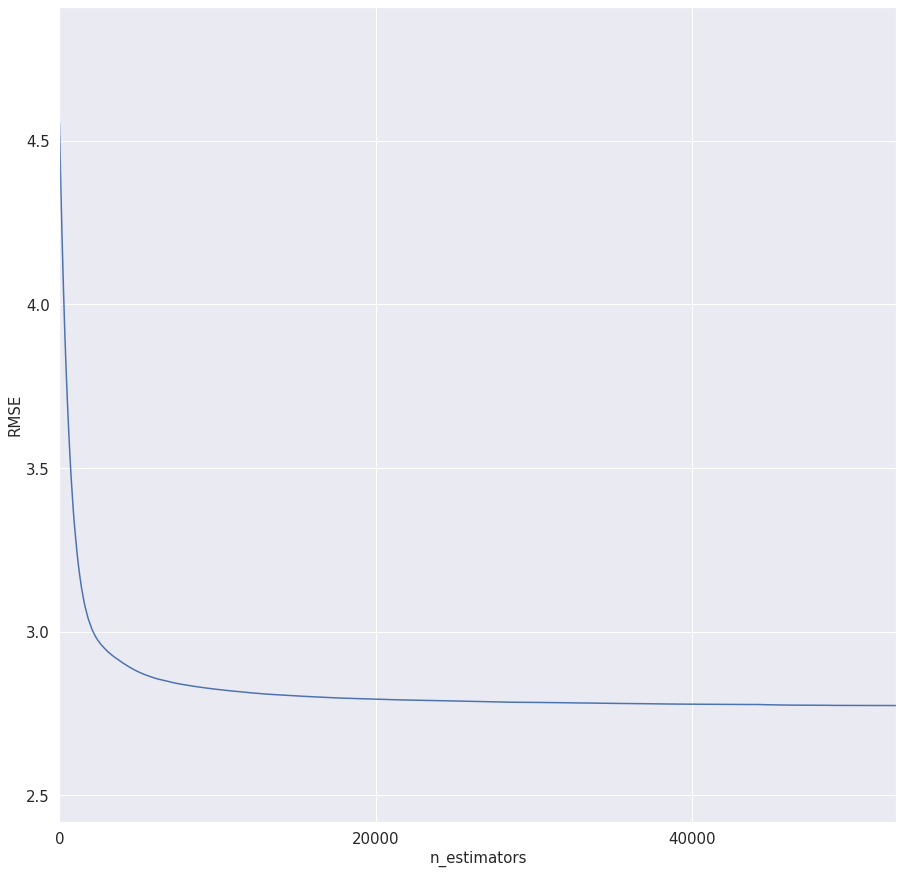

In [358]:

fig = lgb.plot_metric(model, metric='rmse',figsize=(15,15))
fig.get_figure().gca().set_title("")
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
fig.set_xlabel('n_estimators', fontsize=15)
fig.set_ylabel('RMSE', fontsize=15)
fig.get_legend().remove()
plt.savefig('learning curve_v2.svg')
plt.show()


In [118]:
model

LGBMRegressor(bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8,
              lambda_l1=0.9, lambda_l2=0.1, learning_rate=0.001, max_bin=325,
              max_depth=21, metrics='rmse', min_data_in_leaf=50,
              n_estimators=100000, num_leaves=55, objective='regression')

### shap for feature importance ranking

In [360]:
# print the JS visualization code to the notebook
shap.initjs()

In [361]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(predictor)

In [362]:
import joblib

joblib.dump(shap_values, 'shap_values_v2.pkl')
# shap_values = joblib.load("shap_values_v2.pkl")

['shap_values_v2.pkl']

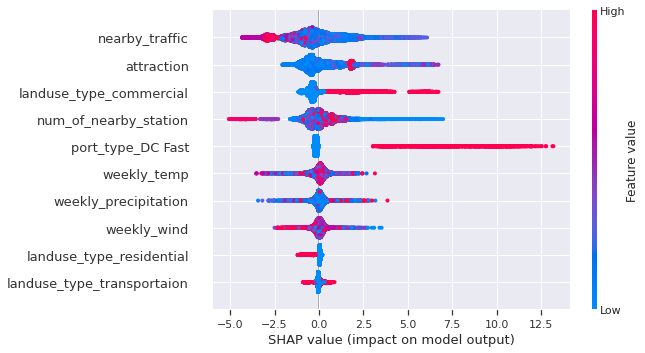

In [363]:
# summarize the effects of all the features
shap.summary_plot(shap_values, predictor,max_display=10)
#almost negative relation except some points between 0-2.5

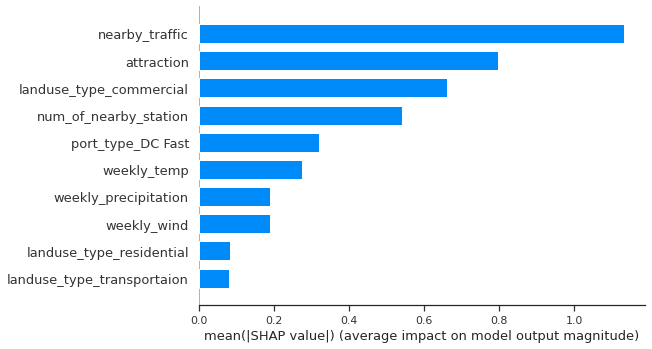

In [117]:
shap.summary_plot(shap_values, predictor, plot_type="bar",max_display=10)

## Stage Two model

### Visualization

In [6]:
shapefile = gpd.read_file('cb_2018_us_zcta510_500k.shp')
shapefile_existing = shapefile[shapefile['ZCTA5CE10'].astype(int).isin(df['Postal Code'])]

<AxesSubplot:>

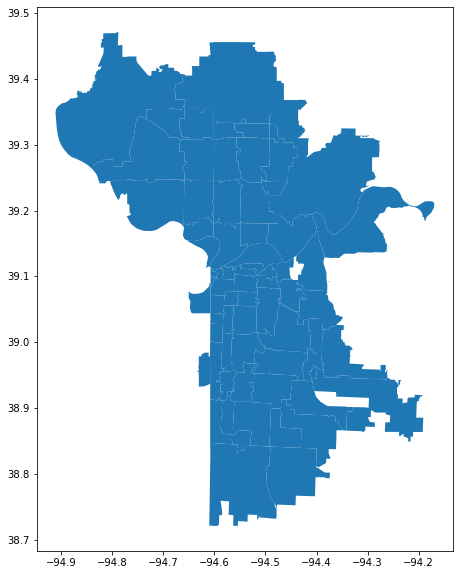

In [350]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))

shapefile_installed_empty.plot( ax=ax, legend=True)

<AxesSubplot:>

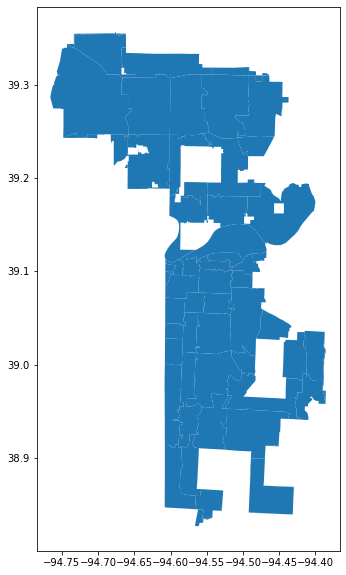

In [24]:
df_intersection_zip_boundary = gpd.read_file("site_selection_gis/Intersection_zip_boundary.shp")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
df_intersection_zip_boundary.plot( ax=ax, legend=True)

In [8]:
df_intersection_zip_boundary = gpd.read_file("site_selection_gis/Intersection_zip_boundary.shp")
zip_existing = shapefile_existing['ZCTA5CE10'].astype(int).tolist()
zip_all_boundary = df_intersection_zip_boundary['ZCTA5CE10'].astype(int).tolist()

shapefile_installed_empty =  shapefile[shapefile['ZCTA5CE10'].astype(int).isin(set(zip_all_boundary))]

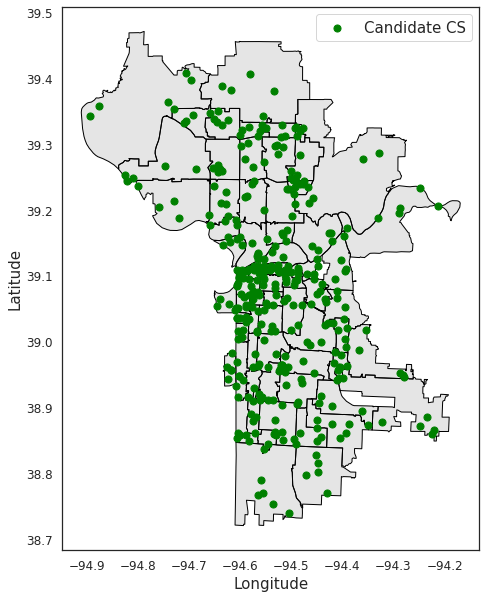

In [116]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))

# df_intersection_zip_boundary.plot( ax=ax, legend=True,color='blue',alpha = 1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_candicate_location.plot( ax=ax, legend=True,color='green',markersize=50,label = 'Candidate CS')
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig('candidate_cs_distribution.svg')

In [106]:
len(gdf_candicate_location)

355

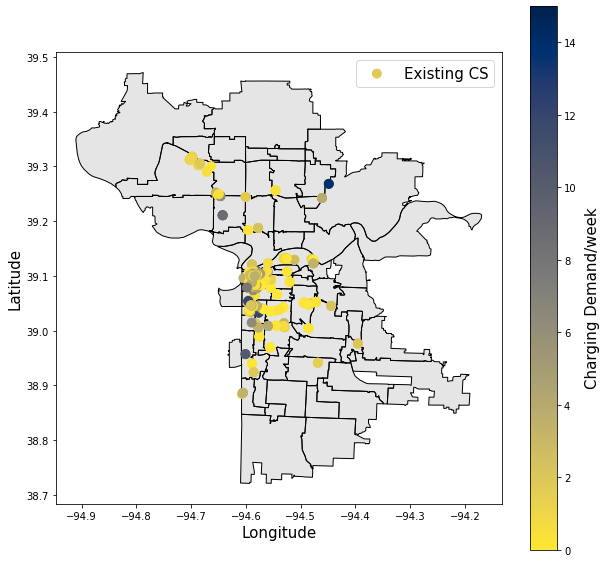

In [80]:
predictor_existing_rate = model.predict(predictor_existing.sort_index())
predictor_existing_rate[np.where(predictor_existing_rate<0)]=0
gdf_station_gis['predictor_existing_rate'] = predictor_existing_rate

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
color_map = plt.cm.get_cmap('cividis')
reversed_color_map = color_map.reversed()
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_station_gis.plot(column='predictor_existing_rate', ax=ax, \
    legend=True,cmap=reversed_color_map,markersize=80,label = 'Existing CS',\
        vmin=0, vmax=15)
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=1)
ax.text(-93.98,38.9,'Charging Demand/week',fontsize=15,rotation=90)
fig.savefig('existing_cs_rate_distribution.svg')

In [33]:
print('num of candidate location:',len(df_candicate_location))
print('num of existing location:',len(set(df_station_rate_1['EVSE ID'])))
# print('num of existing location:',len(set(df_station_rate['EVSE ID'])))
print('num of existing location:',len(set(df['EVSE ID'])))
print('num of existing location:',len(set(df_station_gis['evse_id'])))

num of candidate location: 355
num of existing location: 444
num of existing location: 444
num of existing location: 444


In [307]:
type(df_intersection_zip_boundary)

geopandas.geodataframe.GeoDataFrame

In [310]:
import geopandas as gpd


# open file
gdf = df_intersection_zip_boundary

# add neighbors column
gdf["neighbors"] = None  

for index, zip_zone in gdf.iterrows():   

    # get 'not disjoint' countries
    neighbors = gdf[~gdf.geometry.disjoint(zip_zone.geometry)].ZCTA5CE10.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if zip_zone.ZCTA5CE10 != name ]
    # neighbors = [int(i) for i in neighbors]
    # add names of neighbors as NEIGHBORS value
    gdf.at[index, "neighbors"] = ", ".join(neighbors)
   
# save GeoDataFrame as a new file
gdf.to_file("df_intersection_zip_boundary_neighbors_v2.shp")

In [311]:
gdf['neighbors_int']=None
for i in gdf.index:
    x = gdf.loc[i,'neighbors'].split(',')

    gdf.at[i,'neighbors_int'] = [int(i) for i in x] ###!!!!
gdf['ZCTA5CE10'] = gdf['ZCTA5CE10'].astype(int) 

In [312]:

def get_boundary(gdf):
    list_lat = []
    list_lon = [] 
    for x in list(gdf.convex_hull.exterior.coords):
        list_lat.append(x[1])
        list_lon.append(x[0])

    lat_min = min(list_lat)
    lat_max = max(list_lat)
    lon_min = min(list_lon)
    lon_max = max(list_lon)
    return lat_min, lat_max,lon_min,lon_max

In [317]:
tmp_gdf_boundary = pd.DataFrame(gdf['geometry'].map(get_boundary).tolist(),columns=['lat_min','lat_max','lon_min','lon_max'])
gdf['lat_min'] = tmp_gdf_boundary['lat_min']
gdf['lat_max'] = tmp_gdf_boundary['lat_max']
gdf['lon_min'] = tmp_gdf_boundary['lon_min']
gdf['lon_max'] = tmp_gdf_boundary['lon_max']

In [320]:
gdf['lat_cadidate'] = None
gdf['lon_cadidate'] = None
for i in gdf.index:
    gdf.at[i,'lat_cadidate'] = gdf[(gdf['lat_min'] < gdf.loc[i,'lat_min'])&(gdf['lat_max'] > gdf.loc[i,'lat_min'])|\
    (gdf['lat_max'] > gdf.loc[i,'lat_max'])&(gdf['lat_min'] < gdf.loc[i,'lat_max'])]['ZCTA5CE10'].values

    gdf.at[i,'lon_cadidate'] = gdf[(gdf['lon_min'] < gdf.loc[i,'lon_min'])&(gdf['lon_max'] > gdf.loc[i,'lon_min'])|\
    (gdf['lon_max'] > gdf.loc[i,'lon_max'])&(gdf['lon_min'] < gdf.loc[i,'lon_max'])]['ZCTA5CE10'].values


### Candidate location data initialization

In [323]:
# get num_of_nearby_station for candidate
df_candicate_location['num_of_nearby_station'] = 0
df_group=df_candicate_location.groupby('postal_code')

for j in range(len(list(df_group.groups.keys()))):
    x = list(df_group.groups.keys())[j]  #key
    y = df_candicate_location.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe
    df_candicate_location.loc[df_candicate_location['postal_code']==x,'num_of_nearby_station'] = \
        len(df_station_gis[df_station_gis['postal_code']==x])



In [333]:
# get weekly_precipitation, weekly_temp, weekly_wind for candidate

df_candicate_location['duration_start']=df_station_rate_1.loc[54793,'duration_start']
df_candicate_location['duration_end']=df_station_rate_1.loc[54793,'duration_end']
df_candicate_location['weekly_precipitation']=0
df_candicate_location['weekly_temp']=0
df_candicate_location['weekly_wind']=0



for i in range(len(df_candicate_location)):
    df_weather_kc_sub = df_weather_kc[(df_weather_kc['Date'] > df_candicate_location.loc[i , 'duration_start']) & \
    (df_weather_kc['Date'] <= df_candicate_location.loc[i , 'duration_end'])]

    df_candicate_location.loc[i,'weekly_precipitation'] = df_weather_kc_sub['PRCP'].sum()
    df_candicate_location.loc[i,'weekly_temp'] = df_weather_kc_sub['TAVG'].mean()
    df_candicate_location.loc[i,'weekly_wind'] = df_weather_kc_sub['AWND'].mean()
    # same  as df_station_rate_1.loc[[54793]]

In [334]:
# get port_type for candidate
df_candicate_location['port_type_DC Fast'] = df_station_rate_1.loc[54793,'port_type_DC Fast']
df_candicate_location['port_type_Level 2'] = df_station_rate_1.loc[54793,'port_type_Level 2']


In [ ]:
gdf_candicate_location = geopandas.GeoDataFrame(
    df_candicate_location, geometry=geopandas.points_from_xy(df_candicate_location.lon, df_candicate_location.lat))

gdf_station_gis = geopandas.GeoDataFrame(
    df_station_gis, geometry=geopandas.points_from_xy(df_station_gis.longitude, df_station_gis.latitude))


gdf_candicate_location.set_crs(epsg=4269, inplace=True)

In [336]:
# get attraction for candidate

df_taz = gpd.read_file("site_selection_gis/TAZ/TAZ_2010.shp")

df_candicate_location['attraction'] = np.NaN
for i in gdf_candicate_location.index:
    df_candicate_location.loc[i,'attraction'] = df_taz[df_taz.intersects(gdf_candicate_location.loc[i,'geometry'])]['ATTRACTION'].values[0]

In [343]:
# get nearby_traffic for candidate

df_candicate_location['nearby_traffic'] = 0  

for i in range(len(df_candicate_location)):

    distance_to_node = haversine_vectorize(df_nodes['Longitude'],df_nodes['Latitude'],df_candicate_location.loc[i,'lon'],df_candicate_location.loc[i,'lat'])
    df_nodes_nearby = df_nodes[distance_to_node<1]
    nearby_traffic_mean = df_links[df_links['start'].isin(df_nodes_nearby['Waypoint'].values)]['vol'].mean()

    df_candicate_location.loc[i,'nearby_traffic'] = nearby_traffic_mean
df_candicate_location['nearby_traffic'] = df_candicate_location['nearby_traffic'].fillna(0)



In [344]:
# get neighbors for candidate

gdf['ZCTA5CE10'] = gdf['ZCTA5CE10'].astype(int)
df_candicate_location['neighbors']=None
for i in df_candicate_location.index:
    df_candicate_location.loc[i,'neighbors'] = gdf.loc[gdf['ZCTA5CE10']==df_candicate_location.loc[i,'postal_code'],'neighbors_int'].values


In [346]:
gdf_landuse_parcel_NAD83 = gpd.read_file("site_selection_gis/landuse_parcel_NAD83.cpg.shp")
gdf_landuse_parcel_NAD83['landuse_type'] = df_landuse_parcel['landuse_type']

In [347]:
for i in gdf_candicate_location.index:
    gdf_landuse_parcel_NAD83_sub = gdf_landuse_parcel_NAD83[gdf_landuse_parcel_NAD83.intersects(gdf_candicate_location.loc[i,'geometry'])]
    if len(gdf_landuse_parcel_NAD83_sub) > 0: 
        # find the intersected parcel
        df_candicate_location.loc[i,'landuse_type'] = gdf_landuse_parcel_NAD83_sub['landuse_type'].values[0]
    else:
        #find nearest parcel
        df_candicate_location.loc[i,'landuse_type'] = \
            gdf_landuse_parcel_NAD83.loc[gdf_landuse_parcel_NAD83.distance(gdf_candicate_location.loc[i,'geometry']).sort_values().index[0],'landuse_type']
        

In [724]:
# get lat_cadidate, lon_cadidate for candidate
# get predictor_candidate

df_candicate_location['lat_cadidate'] = None
df_candicate_location['lon_cadidate'] = None

for i in df_candicate_location.index:
    df_candicate_location.loc[i,'lat_cadidate'] = gdf.loc[gdf['ZCTA5CE10']==df_candicate_location.loc[i,'postal_code'],'lat_cadidate'].values
    df_candicate_location.loc[i,'lon_cadidate'] = gdf.loc[gdf['ZCTA5CE10']==df_candicate_location.loc[i,'postal_code'],'lon_cadidate'].values

In [80]:
landuse_type_candidate = pd.get_dummies(df_candicate_location['landuse_type'], prefix = 'landuse_type')
df_candicate_location_1 = pd.concat([df_candicate_location.drop(['landuse_type'],axis=1),landuse_type_candidate],axis=1)


In [81]:
predictor_candidate = df_candicate_location_1[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]


In [732]:
df_station_rate_1_54793 = df_station_rate_1[df_station_rate_1['duration_start']==df_station_rate_1.loc[54793,'duration_start']]
df_station_rate_1_54793  #386 stations

df_station_rate_1_other=pd.DataFrame()

for i in list(set(df_station_rate_1['EVSE ID'])-set(df_station_rate_1_54793['EVSE ID'])):
    df_station_rate_1_sub = df_station_rate_1[df_station_rate_1['EVSE ID'] == i]
    df_station_rate_1_other = df_station_rate_1_other.append(df_station_rate_1_sub.iloc[int(len(df_station_rate_1_sub.index)//2)])

df_station_rate_1_other  #58 stations


df_existing_location = df_station_rate_1_54793.append(df_station_rate_1_other) #444


In [737]:
df_existing_location['neighbors']=None
for i in df_existing_location.index:
    df_existing_location.loc[i,'neighbors'] = gdf.loc[gdf['ZCTA5CE10']==df_existing_location.loc[i,'postal_code'],'neighbors_int'].values


In [740]:
df_existing_location['lat_cadidate'] = None
df_existing_location['lon_cadidate'] = None

for i in df_existing_location.index:
    df_existing_location.loc[i,'lat_cadidate'] = gdf.loc[gdf['ZCTA5CE10']==df_existing_location.loc[i,'postal_code'],'lat_cadidate'].values
    df_existing_location.loc[i,'lon_cadidate'] = gdf.loc[gdf['ZCTA5CE10']==df_existing_location.loc[i,'postal_code'],'lon_cadidate'].values

predictor_existing = df_existing_location[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

In [79]:
list_postal = []
dict_postal_id = {}

df_group=df_candicate_location.groupby('postal_code')

for j in range(len(list(df_group.groups.keys()))):
    x = list(df_group.groups.keys())[j]  #key
    y = df_candicate_location.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe
    list_postal.append(x)
    dict_postal_id[x] = set(y['candidate_id'])
    


In [749]:
#initial solution
initial_selection = []

df_group=df_candicate_location.groupby('postal_code')

for j in range(21,len(list(df_group.groups.keys()))):  #21-71
# for j in range(len(list(df_group.groups.keys()))-19):
    x = list(df_group.groups.keys())[j]  #key
    y = df_candicate_location.loc[df_group.groups[list(df_group.groups.keys())[j]],:]  #extracted dataframe
    initial_selection.append(y.iloc[[0]].index[0])
    
len(initial_selection)

predictor_candidate_selected_initial = predictor_candidate[predictor_candidate.index.isin(initial_selection)]
df_candicate_location_selected_initial = df_candicate_location[df_candicate_location.index.isin(initial_selection)]

In [753]:
len(df_candicate_location_selected_initial)

50

In [752]:
df_candicate_location_selected_count = pd.DataFrame(df_candicate_location_selected_initial['postal_code'].value_counts())
df_candicate_location_selected_count

,postal_code
64112.0,1
64164.0,1
64157.0,1
64149.0,1
66115.0,1
64150.0,1
64139.0,1
64146.0,1
64131.0,1
64161.0,1


In [745]:
df_existing_location_selected_count = pd.DataFrame(df_existing_location['postal_code'].value_counts())
df_existing_location_selected_count

,postal_code
64108.0,77
64105.0,68
64106.0,36
64153.0,34
64111.0,34
64120.0,32
64132.0,19
64127.0,15
64154.0,15
64133.0,12


## solution algorithm

In [2]:
import joblib

# joblib.dump([df,df_station_rate_1,df_landuse_parcel,intersection_station_landuse_442,df_station_gis], 'data_site_selection_v2.pkl')
df,df_station_rate_1,df_landuse_parcel,intersection_station_landuse_442,df_station_gis = joblib.load("data_site_selection_v2.pkl") 

In [3]:
import joblib

# joblib.dump([predictor_existing,\
#     predictor_candidate,\
#     predictor_candidate_selected_initial,\
#         df_existing_location,\
#             df_candicate_location,\
#                 df_candicate_location_1,\
#                 df_candicate_location_selected_initial,\
#                     zip_all_boundary,\
#                         dict_postal_id,\
#                             list_postal], 'data_site_selection_for_optimization.pkl')
                    
predictor_existing,\
    predictor_candidate,\
        predictor_candidate_selected_initial,\
            df_existing_location,\
            df_candicate_location,\
                df_candicate_location_1,\
                df_candicate_location_selected_initial,\
                    zip_all_boundary,\
                        dict_postal_id,\
                            list_postal = joblib.load("data_site_selection_for_optimization.pkl")


# joblib.dump(model, 'model_final_v2.pkl')
model = joblib.load("model_final_v2.pkl")



In [ ]:
gdf_candicate_location = geopandas.GeoDataFrame(
    df_candicate_location, geometry=geopandas.points_from_xy(df_candicate_location.lon, df_candicate_location.lat))

gdf_station_gis = geopandas.GeoDataFrame(
    df_station_gis, geometry=geopandas.points_from_xy(df_station_gis.longitude, df_station_gis.latitude))


gdf_candicate_location.set_crs(epsg=4269, inplace=True)

### Benchmark : naïve greedy selection strategy

In [72]:
num_nearby_station = {}
for zip in zip_all_boundary:
    num_nearby_station[zip] = len(df_existing_location[df_existing_location['postal_code'] == zip ])

for idx in df_existing_location.index:
    df_existing_location.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_existing_location.loc[idx,'postal_code']]
for idx in df_candicate_location_1.index:
    df_candicate_location_1.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_candicate_location_1.loc[idx,'postal_code']]


predictor_existing = df_existing_location[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

predictor_candidate = df_candicate_location_1[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

objection_candidate = model.predict(predictor_candidate)

objection_existing = model.predict(predictor_existing)
    

In [73]:
df_objection_candidate_355 = pd.DataFrame({'objection':objection_candidate})
df_objection_candidate_355 = df_objection_candidate_355.sort_values(by=['objection'],ascending=False)
df_objection_candidate_355

,objection
65,13.953379
116,10.697491
102,10.645394
100,10.561037
197,9.974814
...,...
281,-0.049295
86,-0.195292
347,-0.231373
35,-0.331520


In [74]:
zip_station_count ={}

for zip in zip_all_boundary:
    zip_station_count[zip] = 0

df_existing_location_top50_selected= pd.DataFrame()
for i in df_objection_candidate_355.index:
    if zip_station_count[df_candicate_location_1.loc[i,'postal_code']]<=2:
        df_existing_location_top50_selected = df_existing_location_top50_selected.append(df_candicate_location_1.loc[i])
        zip_station_count[df_candicate_location_1.loc[i,'postal_code']]+=1
    else:
        print(df_objection_candidate_355.index.get_loc(i))
    if len(df_existing_location_top50_selected) == 50:
        break

    

49


In [75]:
objection_candidate_top50_sum = objection_candidate[df_existing_location_top50_selected.index].sum()
objection_candidate_top50_sum + objection_existing.sum()  

1459.5168949876913

In [76]:
num_nearby_station = {}
for zip in zip_all_boundary:
    num_nearby_station[zip] = len(df_existing_location[df_existing_location['postal_code'] == zip ])+\
        len(df_existing_location_top50_selected[df_existing_location_top50_selected['postal_code'] == zip ])

for idx in df_existing_location.index:
    df_existing_location.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_existing_location.loc[idx,'postal_code']]
for idx in df_candicate_location_1.index:
    df_candicate_location_1.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_candicate_location_1.loc[idx,'postal_code']]


predictor_existing = df_existing_location[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

predictor_candidate = df_candicate_location_1[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

# model.predict(predictor_candidate)

model.predict(predictor_existing).sum()+objection_candidate_top50_sum
    

1442.7545176191693

In [77]:
model.predict(predictor_candidate.loc[df_existing_location_top50_selected.index]).sum()+model.predict(predictor_existing).sum()

1428.7587297538341

### Greedy-based stochastic spatial search algorithm

In [161]:
#select from neighbour+SA ramdom samples ,greedy
df_candicate_location_selected = df_candicate_location_selected_initial
num_far_postal = 15 
num_far_postal_initial = 15
num_nearby_station = {}
for zip in zip_all_boundary:
    num_nearby_station[zip] = len(df_candicate_location_selected[df_candicate_location_selected['postal_code'] == zip ])+\
        len(df_existing_location[df_existing_location['postal_code'] == zip ])

for idx in df_existing_location.index:
    df_existing_location.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_existing_location.loc[idx,'postal_code']]
for idx in df_candicate_location_1.index:
    df_candicate_location_1.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_candicate_location_1.loc[idx,'postal_code']]


predictor_existing = df_existing_location[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]

predictor_candidate = df_candicate_location_1[['num_of_nearby_station', 'weekly_precipitation',
       'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
       'landuse_type_commercial', 'landuse_type_industry',
       'landuse_type_institutional', 'landuse_type_recreation',
       'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
       'attraction', 'nearby_traffic']]


iteration_process = pd.DataFrame()
detailed_iteration_process = {}
for j in range(50):
# for j in range(50):
    df_candicate_location_selected_updated = df_candicate_location_selected
    objection_before_j = model.predict(predictor_candidate.loc[df_candicate_location_selected.index]).sum()+\
                    model.predict(predictor_existing).sum()
    index_before_j = set(df_candicate_location_selected.index)
    df_detailed_iteration_process=pd.DataFrame()
    for i in df_candicate_location_selected.index:
        # print(i)

        predictor_existing_selected_A = predictor_existing.loc[df_existing_location[df_existing_location['postal_code']==\
            df_candicate_location_selected.loc[i,'postal_code']].index]

        predictor_candidate_selected_A = predictor_candidate.loc[df_candicate_location_selected_updated[df_candicate_location_selected_updated['postal_code']==\
            df_candicate_location_selected.loc[i,'postal_code']].index]

        predictor_existing_selected_A['num_of_nearby_station'] = len(predictor_existing_selected_A)+len(predictor_candidate_selected_A)
        predictor_candidate_selected_A['num_of_nearby_station'] = len(predictor_existing_selected_A)+len(predictor_candidate_selected_A)

        before_sum_A = 0
        if len(predictor_existing_selected_A)>0:
            before_sum_A += model.predict(predictor_existing_selected_A).sum()
        if len(predictor_candidate_selected_A)>0:
            before_sum_A += model.predict(predictor_candidate_selected_A).sum()



        ##########################################################################################
        predictor_existing_selected_A_after = predictor_existing.loc[df_existing_location[df_existing_location['postal_code']==\
            df_candicate_location_selected.loc[i,'postal_code']].index]

        predictor_candidate_selected_A_after = predictor_candidate.loc[df_candicate_location_selected_updated[df_candicate_location_selected_updated['postal_code']==\
            df_candicate_location_selected.loc[i,'postal_code']].index.drop(i)] 


        predictor_existing_selected_A_after['num_of_nearby_station'] = len(predictor_existing_selected_A_after)+len(predictor_candidate_selected_A_after)
        predictor_candidate_selected_A_after['num_of_nearby_station'] = len(predictor_existing_selected_A_after)+len(predictor_candidate_selected_A_after)


        after_sum_A = 0
        if len(predictor_existing_selected_A_after)>0:
            after_sum_A += model.predict(predictor_existing_selected_A_after).sum()
        if len(predictor_candidate_selected_A_after)>0:
            after_sum_A += model.predict(predictor_candidate_selected_A_after).sum()



        ##########################################################################################

        possible_switch = pd.DataFrame()


        if len(df_candicate_location_selected.loc[i,'neighbors'])>0:
            neighbors_postal_set = df_candicate_location_selected.loc[i,'neighbors']

            
            far_postal_set = sample(list(set(list_postal)-set(neighbors_postal_set)-{df_candicate_location_selected.loc[i,'postal_code']}),num_far_postal)
            all_postal_set = far_postal_set + neighbors_postal_set
            for neighbors_postal_element in all_postal_set:

                predictor_existing_selected_B = predictor_existing.loc[df_existing_location[df_existing_location['postal_code']==\
                    neighbors_postal_element].index]

                predictor_candidate_selected_B = predictor_candidate.loc[df_candicate_location_selected_updated[df_candicate_location_selected_updated['postal_code']==\
                    neighbors_postal_element].index]
                    
                predictor_existing_selected_B['num_of_nearby_station'] = len(predictor_existing_selected_B)+len(predictor_candidate_selected_B)
                predictor_candidate_selected_B['num_of_nearby_station'] = len(predictor_existing_selected_B)+len(predictor_candidate_selected_B)

                before_sum_B = 0

                if len(predictor_existing_selected_B)>0:
                    before_sum_B += model.predict(predictor_existing_selected_B).sum()
                if len(predictor_candidate_selected_B)>0:
                    before_sum_B += model.predict(predictor_candidate_selected_B).sum()

                neighbors_id_set = dict_postal_id[neighbors_postal_element] - set(df_candicate_location_selected_updated['candidate_id'])
                if len(neighbors_id_set) >= 3:  # here is no more than 3 in one zip code
                    for neighbors_id_element in list(neighbors_id_set):
                        # print(neighbors_id_element)
            ##########################################################################################
                        predictor_existing_selected_B_after = predictor_existing.loc[df_existing_location[df_existing_location['postal_code']==\
                            neighbors_postal_element].index]
                            
                        selected_index = df_candicate_location[df_candicate_location['candidate_id']==neighbors_id_element].index
                        predictor_candidate_selected_B_after = predictor_candidate.loc[df_candicate_location_selected_updated[df_candicate_location_selected_updated['postal_code']==\
                            neighbors_postal_element].index.union(selected_index)]
                            
                        predictor_existing_selected_B_after['num_of_nearby_station'] = len(predictor_existing_selected_B_after)+len(predictor_candidate_selected_B_after)
                        predictor_candidate_selected_B_after['num_of_nearby_station'] = len(predictor_existing_selected_B_after)+len(predictor_candidate_selected_B_after)

                        after_sum_B = 0

                        if len(predictor_existing_selected_B_after)>0:
                            after_sum_B += model.predict(predictor_existing_selected_B_after).sum()
                        if len(predictor_candidate_selected_B_after)>0:
                            after_sum_B += model.predict(predictor_candidate_selected_B_after).sum()

                        if (before_sum_A+before_sum_B) < (after_sum_A+after_sum_B):

                            possible_switch = possible_switch.append({"index_df_candicate_location_selected":df_candicate_location_selected.index.get_loc(i),\
                                "main_postal_element":df_candicate_location_selected.loc[i,'postal_code'],\
                                "main_index_element":i,\
                                "target_postal_element":neighbors_postal_element,\
                                    "is_far_postal":neighbors_postal_element in far_postal_set,\
                                "target_id_element":neighbors_id_element,\
                                "before_sum_A":before_sum_A,\
                                "before_sum_B":before_sum_B,\
                                "after_sum_A":after_sum_A,\
                                    "after_sum_B":after_sum_B,\
                                        "before_sum":before_sum_A + before_sum_B,\
                                            "after_sum":after_sum_A + after_sum_B,\
                                                "difference":(after_sum_A + after_sum_B)-(before_sum_A + before_sum_B)}, ignore_index= True)

        if len(possible_switch)>0:
            objection_before = model.predict(predictor_candidate.loc[df_candicate_location_selected.index]).sum()+\
                            model.predict(predictor_existing).sum()  


            possible_switch_optimal = possible_switch.loc[[possible_switch['difference'].idxmax()]] 

            df_candicate_location_selected_updated = df_candicate_location_selected_updated.drop(possible_switch_optimal['main_index_element'])
            df_candicate_location_selected_updated = df_candicate_location_selected_updated.append\
                (df_candicate_location[df_candicate_location['candidate_id'] == possible_switch_optimal['target_id_element'].values[0]])

            num_nearby_station = {}
            for zip in zip_all_boundary:
                num_nearby_station[zip] = len(df_candicate_location_selected_updated[df_candicate_location_selected_updated['postal_code'] == zip ])+\
                    len(df_existing_location[df_existing_location['postal_code'] == zip ])

            df_existing_location_updated = copy.deepcopy(df_existing_location)
            df_candicate_location_1_updated = copy.deepcopy(df_candicate_location_1)
            for idx in df_existing_location_updated.index:
                df_existing_location_updated.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_existing_location_updated.loc[idx,'postal_code']]
            for idx in df_candicate_location_1_updated.index:
                df_candicate_location_1_updated.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_candicate_location_1_updated.loc[idx,'postal_code']]

            predictor_existing_updated = df_existing_location_updated[['num_of_nearby_station', 'weekly_precipitation',
                'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
                'landuse_type_commercial', 'landuse_type_industry',
                'landuse_type_institutional', 'landuse_type_recreation',
                'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
                'attraction', 'nearby_traffic']]

            predictor_candidate_updated = df_candicate_location_1_updated[['num_of_nearby_station', 'weekly_precipitation',
                'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
                'landuse_type_commercial', 'landuse_type_industry',
                'landuse_type_institutional', 'landuse_type_recreation',
                'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
                'attraction', 'nearby_traffic']]

    


            df_detailed_iteration_process = df_detailed_iteration_process.append(possible_switch_optimal,ignore_index = True)  
            # print(possible_switch_optimal.index)
        else:
            
            df_detailed_iteration_process = df_detailed_iteration_process.append({"index_df_candicate_location_selected":df_candicate_location_selected.index.get_loc(i),\
                                "main_postal_element":df_candicate_location_selected.loc[i,'postal_code'],\
                                "main_index_element":i,\
                                "target_postal_element":None,\
                                    "is_far_postal":None,\
                                "target_id_element":None,\
                                "before_sum_A":before_sum_A,\
                                "before_sum_B":None,\
                                    "after_sum_A":after_sum_A,\
                                        "after_sum_B":None,\
                                            "before_sum":None,\
                                                "after_sum":None,\
                                                    "difference":None}, ignore_index= True)  #here True resets index of all the rows not just this row
            # print(df_detailed_iteration_process.index)
        df_candicate_location_selected = df_candicate_location_selected_updated

        num_nearby_station = {}
        for zip in zip_all_boundary:
            num_nearby_station[zip] = len(df_candicate_location_selected[df_candicate_location_selected['postal_code'] == zip ])+\
                len(df_existing_location[df_existing_location['postal_code'] == zip ])

        for idx in df_existing_location.index:
            df_existing_location.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_existing_location.loc[idx,'postal_code']]
        for idx in df_candicate_location_1.index:
            df_candicate_location_1.loc[idx,'num_of_nearby_station'] = num_nearby_station[df_candicate_location_1.loc[idx,'postal_code']]


        predictor_existing = df_existing_location[['num_of_nearby_station', 'weekly_precipitation',
            'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
            'landuse_type_commercial', 'landuse_type_industry',
            'landuse_type_institutional', 'landuse_type_recreation',
            'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
            'attraction', 'nearby_traffic']]

        predictor_candidate = df_candicate_location_1[['num_of_nearby_station', 'weekly_precipitation',
            'weekly_temp', 'weekly_wind', 'port_type_DC Fast', 'port_type_Level 2',
            'landuse_type_commercial', 'landuse_type_industry',
            'landuse_type_institutional', 'landuse_type_recreation',
            'landuse_type_residential', 'landuse_type_transportaion', 'landuse_type_vacant',
            'attraction', 'nearby_traffic']]

            
    detailed_iteration_process[j] = df_detailed_iteration_process
    
            


    objection_after = model.predict(predictor_candidate_updated.loc[df_candicate_location_selected_updated.index]).sum()+\
        model.predict(predictor_existing_updated).sum()
    print(objection_after - objection_before_j)

    iteration_process = iteration_process.append({"selection_before":index_before_j,\
        "objection_before":objection_before_j,\
            "selection_after":set(df_candicate_location_selected_updated.index),\
                                "objection_after":objection_after,\
                                "difference":objection_after - objection_before_j,\
                                    "num_far_postal":num_far_postal}, ignore_index= True)
    num_far_postal = int(np.ceil(detailed_iteration_process[j]['is_far_postal'].sum()/len(df_candicate_location_selected)*num_far_postal_initial))


    # num_far_postal = int(np.ceil((-detailed_iteration_process[j]['target_postal_element'].isna()).sum()/len(df_candicate_location_selected)*num_far_postal_initial))
    

    if objection_after - objection_before_j<0.01:
        break

result_dict_random_SA_greedy = {'iteration_process':iteration_process,\
    'detailed_iteration_process':detailed_iteration_process}

176.51427753357643
4.361098670892488
0.2929974881583348
0.0


In [163]:

joblib.dump(result_dict_random_SA_greedy, 'result_dict_random_SA_greedy.pkl')
# result_dict_random_SA_greedy = joblib.load("result_dict_random_SA_greedy.pkl")
# 8min50s, 1459.18 optimal, for last iteration, no fa postal area

['result_dict_random_SA_greedy.pkl']

In [124]:
detailed_iteration_process[0]

,index_df_candicate_location_selected,main_postal_element,main_index_element,target_postal_element,is_far_postal,target_id_element,before_sum_A,before_sum_B,after_sum_A,after_sum_B,before_sum,after_sum,difference
0,0.0,64112.0,0.0,64105.0,1.0,167.0,39.869313,244.005681,39.289771,251.388010,283.874994,290.677781,6.802787
1,0.0,64125.0,5.0,64120.0,0.0,147.0,4.552026,48.140867,0.000000,60.524880,52.692894,60.524880,7.831986
2,0.0,64109.0,10.0,64118.0,1.0,323.0,1.638706,13.991418,0.000000,24.995421,15.630124,24.995421,9.365297
3,0.0,64165.0,15.0,64081.0,1.0,229.0,1.450863,0.000000,0.000000,8.116326,1.450863,8.116326,6.665463
4,0.0,64158.0,20.0,64157.0,0.0,180.0,15.096086,25.978284,13.553073,32.739119,41.074370,46.292193,5.217822
5,0.0,64114.0,25.0,64131.0,0.0,270.0,27.307630,11.082375,26.873497,17.645669,38.390006,44.519166,6.129160
6,0.0,66103.0,30.0,64111.0,0.0,40.0,1.990684,106.056886,0.000000,112.622830,108.047570,112.622830,4.575261
7,0.0,64111.0,35.0,66206.0,1.0,334.0,112.622830,6.501822,111.616884,11.777594,119.124652,123.394478,4.269825
8,0.0,64123.0,40.0,64125.0,0.0,6.0,1.693343,0.000000,0.000000,4.552026,1.693343,4.552026,2.858684
9,0.0,64130.0,45.0,64153.0,1.0,283.0,3.938480,40.176320,3.373127,46.289866,44.114800,49.662994,5.548194


In [162]:
iteration_process

,selection_before,objection_before,selection_after,objection_after,difference,num_far_postal
0,"{0, 130, 260, 5, 135, 265, 10, 140, 270, 15, 1...",1278.010909,"{5, 6, 139, 269, 270, 145, 146, 17, 280, 282, ...",1454.525186,176.514278,15.0
1,"{5, 6, 139, 269, 270, 145, 146, 17, 280, 282, ...",1454.525186,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1458.886285,4.361099,10.0
2,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1458.886285,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.179282,0.292997,1.0
3,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.179282,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.179282,0.000000,1.0


## Result of stage 2 model

In [ ]:
result_dict_random_greedy['iteration_process']

,selection_before,objection_before,selection_after,objection_after,difference
0,"{0, 130, 260, 5, 135, 265, 10, 140, 270, 15, 1...",1278.010909,"{5, 6, 139, 269, 16, 145, 146, 17, 280, 282, 1...",1451.057107,173.046199
1,"{5, 6, 139, 269, 16, 145, 146, 17, 280, 282, 1...",1451.057107,"{5, 6, 269, 270, 16, 145, 146, 17, 280, 282, 1...",1456.800222,5.743115
2,"{5, 6, 269, 270, 16, 145, 146, 17, 280, 282, 1...",1456.800222,"{5, 6, 139, 269, 16, 145, 146, 17, 280, 282, 1...",1458.140528,1.340306
3,"{5, 6, 139, 269, 16, 145, 146, 17, 280, 282, 1...",1458.140528,"{5, 139, 269, 270, 16, 145, 146, 17, 280, 282,...",1458.447840,0.307311
4,"{5, 139, 269, 270, 16, 145, 146, 17, 280, 282,...",1458.447840,"{5, 6, 139, 269, 270, 145, 146, 280, 282, 158,...",1458.893355,0.445516
5,"{5, 6, 139, 269, 270, 145, 146, 280, 282, 158,...",1458.893355,"{5, 6, 139, 269, 270, 145, 146, 17, 280, 282, ...",1458.997878,0.104523
6,"{5, 6, 139, 269, 270, 145, 146, 17, 280, 282, ...",1458.997878,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.023771,0.025893
7,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.023771,"{5, 6, 139, 269, 270, 16, 145, 146, 17, 280, 2...",1459.023771,0.000000


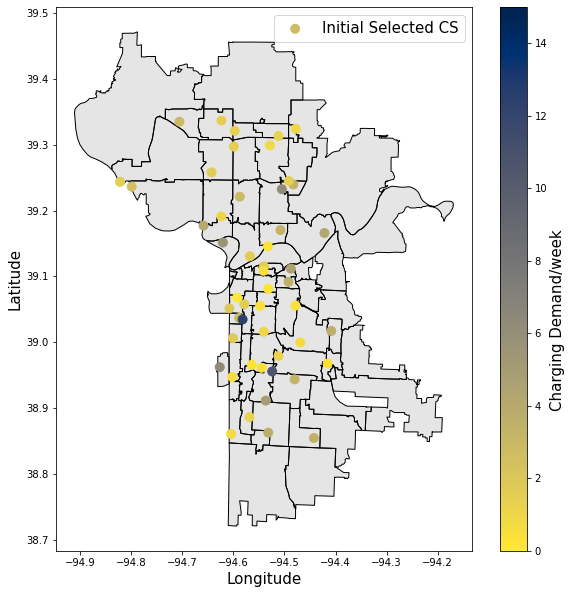

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
color_map = plt.cm.get_cmap('cividis')
reversed_color_map = color_map.reversed()
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_candicate_location_selected_initial.plot(column='demand', ax=ax, \
    legend=True,cmap=reversed_color_map,markersize=80,label = 'Initial Selected CS',\
        vmin=0, vmax=15)
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=1)
ax.text(-93.98,38.9,'Charging Demand/week',fontsize=15,rotation=90)
fig.savefig('gdf_candicate_location_selected_initial.svg')

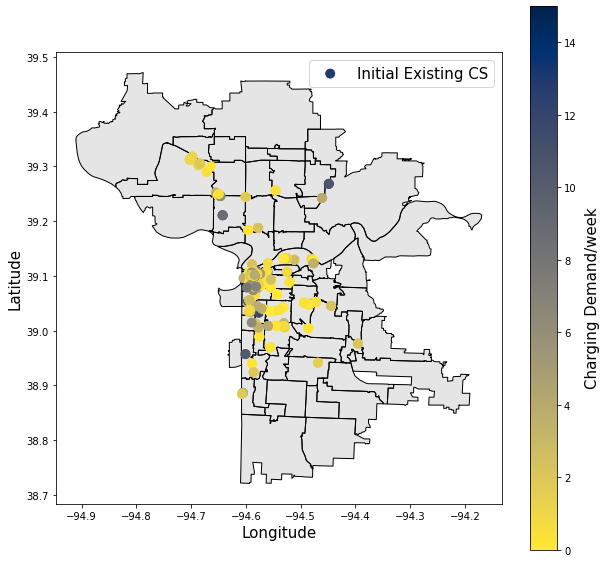

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
color_map = plt.cm.get_cmap('cividis')
reversed_color_map = color_map.reversed()
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_existing_location_initial.plot(column='demand', ax=ax, \
    legend=True,cmap=reversed_color_map,markersize=80,label = 'Initial Existing CS',\
        vmin=0, vmax=15)
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=1)
ax.text(-93.98,38.9,'Charging Demand/week',fontsize=15,rotation=90)
fig.savefig('gdf_existing_location_initial.svg')

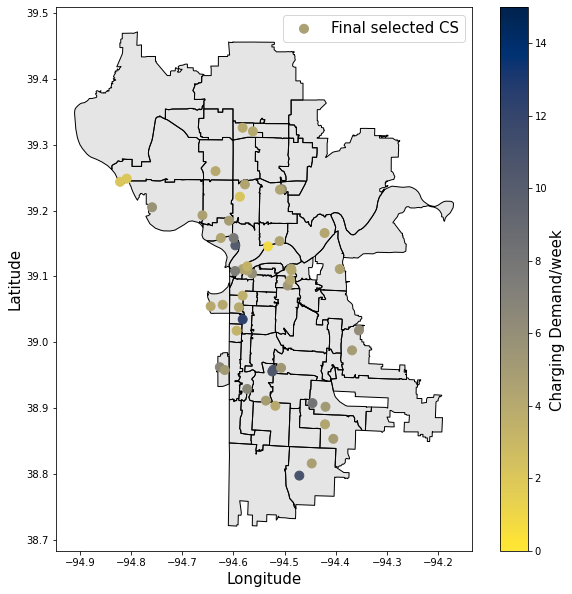

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
color_map = plt.cm.get_cmap('cividis')
reversed_color_map = color_map.reversed()
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_candicate_location_selected_final.plot(column='demand', ax=ax, \
    legend=True,cmap=reversed_color_map,markersize=80,label = 'Final selected CS',\
        vmin=0, vmax=15)
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=1)
ax.text(-93.98,38.9,'Charging Demand/week',fontsize=15,rotation=90)
fig.savefig('gdf_candicate_location_selected_final.svg')

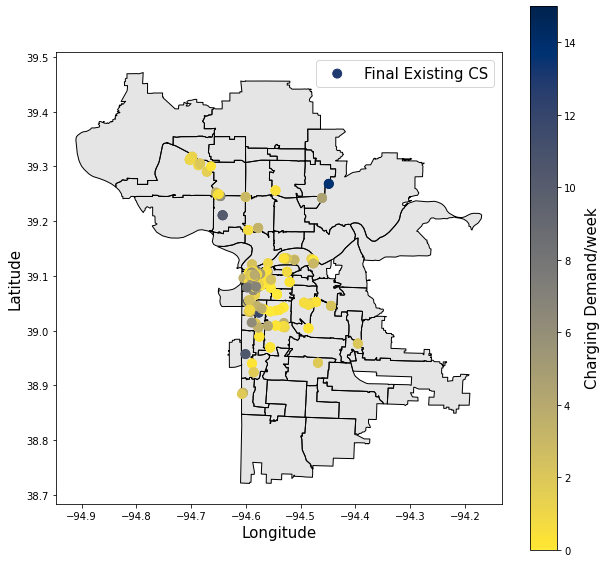

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(10,10))
color_map = plt.cm.get_cmap('cividis')
reversed_color_map = color_map.reversed()
shapefile_installed_empty.plot( ax=ax, legend=True,color='black',alpha = 0.1)
shapefile_installed_empty.plot( ax=ax, legend=True,color='None',edgecolor='black')
gdf_existing_location_final.plot(column='demand', ax=ax, \
    legend=True,cmap=reversed_color_map,markersize=80,label = 'Final Existing CS',\
        vmin=0, vmax=15)
ax.legend(loc='best',fontsize = 15)
ax.set_xlabel('Longitude',fontsize = 15)
ax.set_ylabel('Latitude',fontsize = 15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=1)
ax.text(-93.98,38.9,'Charging Demand/week',fontsize=15,rotation=90)
fig.savefig('gdf_existing_location_final.svg')

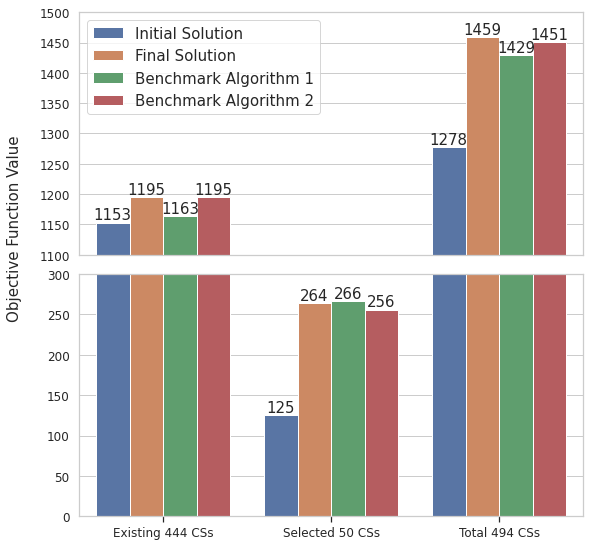

In [ ]:
df = pd.DataFrame({
    'Factor': ['Existing 444 CSs', 'Selected 50 CSs','Total 494 CSs'],
    'Initial Solution': [1153, 125, 1278],
    'Final Solution': [1195, 264, 1459],
    'Benchmark Algorithm 1': [1163, 266, 1429],
    'Benchmark Algorithm 2': [1195, 256, 1451]
})
fig, ax1 = plt.subplots(figsize=(10, 15))
tidy = df.melt(id_vars='Factor').rename(columns=str.title)

# set style for seaborn plot
sns.set(style="whitegrid", font="CMU Sans Serif")
pal = sns.color_palette(n_colors=4)
# let's create a figure for our two plots to live in
# we need a lower part (anything below the cutoff), which will be ax2
# and an upper part (anything above the cutoff) which will be ax1
# because we have only two plots above each other, we set ncols=1 and nrows=2
# also, they should share an x axis, which is why we set sharex=True
f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True,figsize=(10, 10))

# we want the "Test" to appear on the x axis as individual parameters
# "Latency in ms" should be what is shown on the y axis as a value
# hue should be the "Experiment Setup"
# this will result three ticks on the x axis with X1...X3 and each with three bars for T1...T3
# (you could turn this around if you need to, depending on what kind of data you want to show)
ax1 = sns.barplot(x="Factor", y="Value",
                  hue="Variable", data=tidy, palette=pal, ax=ax1)

# we basically do the same thing again for the second plot
ax2 = sns.barplot(x="Factor", y="Value",
                  hue="Variable", data=tidy, palette=pal, ax=ax2)

# here is the fun part: setting the limits for the individual y axis
# the upper part (ax1) should show only values from 250 to 400
# the lower part (ax2) should only show 0 to 150
# you can define your own limits, but the range (150) should be the same so scale is the same across both plots
# it could be possible to use a different range and then adjust plot height but who knows how that works
ax1.set_ylim(1100, 1500)
ax2.set_ylim(0, 300)

# the upper part does not need its own x axis as it shares one with the lower part
ax1.get_xaxis().set_visible(False)

# by default, each part will get its own "Latency in ms" label, but we want to set a common for the whole figure
# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
# then, set a new label on the plot (basically just a piece of text) and move it to where it makes sense (requires trial and error)
f.text(0.05, 0.55, "Objective Function Value", va="center", rotation="vertical",size=15 )

# by default, seaborn also gives each subplot its own legend, which makes no sense at all
# soe remove both default legends first
ax1.get_legend().remove()
ax2.get_legend().remove()
# then create a new legend and put it to the side of the figure (also requires trial and error)
# ax2.legend(loc=(1.025, 0.5),fontsize = 15)

ax1.legend(fontsize = 15)
# let's put some ticks on the top of the upper part and bottom of the lower part for style
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust everything a bit to make it prettier (this just moves everything, best to try and iterate)
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85,hspace=0.08)

# ax1.legend(loc='best',fontsize = 15)
# ax1.set_xlabel('Longitude',fontsize = 15)
# ax1.set_ylabel('Latitude',fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=12)


ax2.set_xlabel('',fontsize = 15)
# ax2.set_ylabel('Latitude',fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=12)

for container in ax1.containers:
    ax1.bar_label(container,fontsize = 15)


for container in ax2.containers:
    ax2.bar_label(container,fontsize = 15)

plt.show()
f.savefig('solution result.svg')